In [1]:
# import acquire script: 
from acquire import get_all_readme_files_and_languages
# import prepare scripts: 
from prepare import prepare_repo_html_data
from prepare import basic_clean
# utility imports and pandas for data analysis:
import re
import unicodedata
import numpy as np
import pandas as pd
# import nltk for language analysis: 
import nltk
#matplotlib and seaborn for plotting: 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# scipy.stats for analysis
from scipy.stats import ttest_ind as ttest
from wordcloud import WordCloud

# sentiment analysis importation
from afinn import Afinn

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Acquire

In [3]:
# initialize our lists of potential excluded and extended stopwords
extra_words = []
exclude_words = []

In [4]:
# gather our repositories through our acquire function:
repositories = get_all_readme_files_and_languages()

# Prepare

In [5]:
# create a transformed dataset dictionary, as well as a dataframe for exploration
transformed_data, df = prepare_repo_html_data(repositories, extra_words, exclude_words)

In [6]:
# iterate through our dataframe to acquire unique languages, and apply transformation to them
for i in range(df.shape[0]):
    next_lang = transformed_data[i]['language'].lower()
    next_lang = re.sub(r'[^\w\s]', ' ', next_lang).strip()
    if next_lang not in extra_words:
        extra_words.append(next_lang)
# Remove languages from the readme files with another call to prepare_repo_html:
transformed_data, df = prepare_repo_html_data(repositories, extra_words, exclude_words)

In [7]:
extra_words = extra_words + ['http'] #http is not in our languages but pops up a lot
extra_words

['c',
 'html',
 'ruby',
 'vue',
 'java',
 'dart',
 'python',
 'css',
 'rust',
 'shell',
 'javascript',
 'go',
 'typescript',
 'scala',
 'kotlin',
 'smarty',
 'emacs lisp',
 'lua',
 'objective c',
 'tex',
 'common lisp',
 'clojure',
 'jupyter notebook',
 'r',
 'powershell',
 'perl',
 'php',
 'http']

In [8]:
transformed_data, df = prepare_repo_html_data(repositories, extra_words, exclude_words)

# Model

In [9]:
df
original_df = df.copy()

# From the lesson:

In [10]:
from pprint import pprint

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from prepare import basic_clean, lemmatize

Text(0.5, 1.0, 'IDF for a given word')

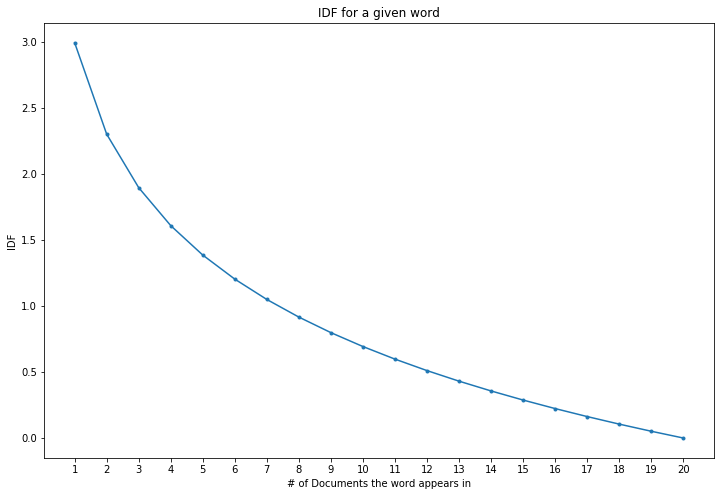

In [11]:
n_documents = 20

x = np.arange(1, n_documents + 1)
y = np.log(n_documents / x)

plt.figure(figsize=(12, 8))
plt.plot(x, y, marker='.')

plt.xticks(x)
plt.xlabel('# of Documents the word appears in')
plt.ylabel('IDF')
plt.title('IDF for a given word')

In [12]:
# our 3 example documents
documents = {
    'news': 'Codeup announced last thursday that they just launched a new data science program. It is 18 weeks long.',
    'description': 'Codeup\'s data science program teaches hands on skills using Python and pandas.',
    'context': 'Codeup\'s data science program was created in response to a percieved lack of data science talent, and growing demand.'
}
pprint(documents)

print('\nCleaning and lemmatizing...\n')

documents = {topic: lemmatize(basic_clean(documents[topic])) for topic in documents}
pprint(documents)

{'context': "Codeup's data science program was created in response to a "
            'percieved lack of data science talent, and growing demand.',
 'description': "Codeup's data science program teaches hands on skills using "
                'Python and pandas.',
 'news': 'Codeup announced last thursday that they just launched a new data '
         'science program. It is 18 weeks long.'}

Cleaning and lemmatizing...

{'context': 'codeup s data science program was created in response to a '
            'percieved lack of data science talent and growing demand',
 'description': 'codeup s data science program teaches hands on skills using '
                'python and pandas',
 'news': 'codeup announced last thursday that they just launched a new data '
         'science program it is 18 weeks long'}


In [13]:
# A simple way to calculate idf for demonstration. Note that this
# function relies on the globally defined documents variable.
def idf(word):
    n_occurences = sum([1 for doc in documents.values() if word in doc])
    return len(documents) / n_occurences

# Get a list of the unique words
unique_words = pd.Series(' '.join(documents.values()).split()).unique()

# put the unique words into a data frame
(pd.DataFrame(dict(word=unique_words))
 # calculate the idf for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # sort the data for presentation purposes
 .set_index('word')
 .sort_values(by='idf', ascending=False)
 .head(5))

,idf
word,
teaches,3.0
created,3.0
hands,3.0
skills,3.0
using,3.0


# TF-IDF

In [14]:
tfs = []

# We'll caclulate the tf-idf value for every word across every document

# Start by iterating over all the documents
for doc, text in documents.items():
    # We'll make a data frame that contains the tf for every word in every document
    df = (pd.Series(text.split())
          .value_counts()
          .reset_index()
          .set_axis(['word', 'raw_count'], axis=1, inplace=False)
          .assign(tf=lambda df: df.raw_count / df.shape[0])
          .drop(columns='raw_count')
          .assign(doc=doc))
    # Then add that data frame to our list
    tfs.append(df)

# We'll then concatenate all the tf values together.
(pd.concat(tfs)
 # calculate the idf value for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # then use the if and idf values to calculate tf-idf 
 .assign(tf_idf=lambda df: df.idf * df.tf)
 .drop(columns=['tf', 'idf'])
 .sort_values(by='tf_idf', ascending=False))

,word,doc,tf_idf
10,teaches,description,0.230769
7,using,description,0.230769
5,pandas,description,0.230769
4,skills,description,0.230769
1,hands,description,0.230769
11,python,description,0.230769
10,percieved,context,0.166667
2,lack,context,0.166667
3,was,context,0.166667
1,thursday,news,0.166667


In [15]:
# We'll then concatenate all the tf values together.
(pd.concat(tfs)
 # calculate the idf value for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # then use the if and idf values to calculate tf-idf 
 .assign(tf_idf=lambda df: df.idf * df.tf)
 .drop(columns=['tf', 'idf'])
 .sort_values(by='tf_idf', ascending=False)
 .pipe(lambda df: pd.crosstab(df.doc, df.word, values=df.tf_idf, aggfunc=lambda x: x))
 .fillna(0))

word,18,a,and,announced,codeup,created,data,demand,growing,hands,...,skills,talent,teaches,that,they,thursday,to,using,was,weeks
doc,,,,,,,,,,,,,,,,,,,,,
context,0.000000,0.055556,0.083333,0.000000,0.055556,0.166667,0.111111,0.166667,0.166667,0.000000,...,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000
description,0.000000,0.000000,0.115385,0.000000,0.076923,0.000000,0.076923,0.000000,0.000000,0.230769,...,0.230769,0.000000,0.230769,0.000000,0.000000,0.000000,0.000000,0.230769,0.000000,0.000000
news,0.166667,0.055556,0.000000,0.166667,0.055556,0.000000,0.055556,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.166667


# TF-IDF with scikit-learn

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(documents.values())
tfidfs

<3x36 sparse matrix of type '<class 'numpy.float64'>'
	with 45 stored elements in Compressed Sparse Row format>

In [17]:
pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())

,18,and,announced,codeup,created,data,demand,growing,hands,in,...,skills,talent,teaches,that,they,thursday,to,using,was,weeks
0,0.263566,0.000000,0.263566,0.155666,0.000000,0.155666,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.263566,0.263566,0.263566,0.000000,0.000000,0.000000,0.263566
1,0.000000,0.253880,0.000000,0.197160,0.000000,0.197160,0.000000,0.000000,0.333821,0.000000,...,0.333821,0.000000,0.333821,0.000000,0.000000,0.000000,0.000000,0.333821,0.000000,0.000000
2,0.000000,0.195932,0.000000,0.152159,0.257627,0.304317,0.257627,0.257627,0.000000,0.257627,...,0.000000,0.257627,0.000000,0.000000,0.000000,0.000000,0.257627,0.000000,0.257627,0.000000


# Modeling

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv('./spam_clean.csv')
df.head()

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.text)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [19]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 97.42%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3857   113
spam          2   485
---
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      3859
        spam       1.00      0.81      0.89       598

   micro avg       0.97      0.97      0.97      4457
   macro avg       0.98      0.91      0.94      4457
weighted avg       0.97      0.97      0.97      4457



In [20]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 96.95%
---
Confusion Matrix
actual     ham  spam
predicted           
ham        965    33
spam         1   116
---
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       0.99      0.78      0.87       149

   micro avg       0.97      0.97      0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [21]:
df = original_df.copy()

In [22]:
new_df = df.copy()
new_df['length_readme'] = new_df['lemmatized'].apply(len)
new_df

,language,lemmatized,original,stemmed,title,length_readme
0,C++,welcome repository contains source code window...,Welcome! This repository contains the source c...,welcome repository contains source code window...,microsoft/Terminal,5864
1,HTML,devops matlab lisp make english working lang...,Python - 100天从新手到大师\n\n作者：骆昊\n\nPython应用领域和就业形...,devops matlab lisp make english working lang...,jackfrued/Python-100-Days,2485
2,Ruby,chat truly monstrous async web chat using js w...,CSS-Only Chat\nA truly monstrous async web cha...,chat truly monstrous async web chat using js w...,kkuchta/css-only-chat,2743
3,Ruby,overview powertoys set utilities power users t...,Overview\nPowerToys is a set of utilities for ...,overview powertoys set utilities power users t...,microsoft/PowerToys,1662
4,Vue,beautifully simple click copy effects https cs...,Beautifully simple click-to-copy CSS effects\n...,beautifully simple click copy effects https cs...,jolaleye/cssfx,210
5,Java,english version readme click leetcode ...,There is an English version of README here. ju...,english version readme click leetcode ...,MisterBooo/LeetCodeAnimation,205
6,Dart,welcome code repository flutter web repository...,Welcome to the code repository for Flutter for...,welcome code repository flutter web repository...,flutter/flutter_web,6661
7,Python,algorithms algorithms implemented education im...,The Algorithms - Python \n\nAll algorithms imp...,algorithms algorithms implemented education im...,TheAlgorithms/Python,13330
8,CSS,make slides markdown easily write markdown cre...,📝 Make slides with Markdown easily.\n\n\n\n\n\...,make slides markdown easily write markdown cre...,hiroppy/fusuma,3159
9,Java,offer leetcode linux socket sql leetcode datab...,离线阅读版本下载\n\n\n\n\n\n 算法 \n操作系统\n 网络 \n面向对象\n ...,offer leetcode linux socket sql leetcode datab...,CyC2018/CS-Notes,331


# Logistic Regression

In [23]:
df1 = df.copy()
# split into test train data
X_train, X_test, y_train, y_test = train_test_split(df1.lemmatized, 
                                                    df1.language, 
                                                    random_state=123)

# make the model
tfidf = TfidfVectorizer()

# fit data to the model
tfidf.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [24]:
# use the model
train_tfidf_values = tfidf.transform(X_train)

# make the model
model = LogisticRegression()

# fit the model
model.fit(train_tfidf_values, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
# make predictions
predictions = model.predict(train_tfidf_values)

In [26]:
# make the classification report
df2 = pd.DataFrame(dict(actual=y_train, predicted=predictions))
pd.crosstab(df2.predicted,df2.actual)
print(classification_report(df2.actual, df2.predicted))

              precision    recall  f1-score   support

           C       0.00      0.00      0.00         2
          C#       0.00      0.00      0.00         1
         C++       0.00      0.00      0.00         8
         CSS       0.00      0.00      0.00         2
 Common Lisp       0.00      0.00      0.00         1
        Dart       1.00      0.33      0.50         3
          Go       1.00      0.11      0.20         9
        HTML       0.00      0.00      0.00         5
        Java       1.00      0.64      0.78        14
  JavaScript       0.36      1.00      0.53        37
      Kotlin       0.00      0.00      0.00         3
         Lua       0.00      0.00      0.00         1
 Objective-C       0.00      0.00      0.00         5
         PHP       0.00      0.00      0.00         3
        Perl       0.00      0.00      0.00         1
      Python       1.00      1.00      1.00        19
           R       0.00      0.00      0.00         1
        Ruby       0.00    

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
# See how well the model performs on the test data.
test_tfidf_values = tfidf.transform(X_test)
test_predictions = model.predict(test_tfidf_values)
print('Accuracy: {:.2%}'.format(accuracy_score(df2.predicted, df2.actual)))
print(classification_report(y_test, test_predictions))

Accuracy: 51.82%
                  precision    recall  f1-score   support

              C#       0.00      0.00      0.00         1
             C++       0.00      0.00      0.00         6
         Clojure       0.00      0.00      0.00         1
      Emacs Lisp       0.00      0.00      0.00         1
              Go       0.00      0.00      0.00         2
            HTML       0.00      0.00      0.00         2
            Java       0.00      0.00      0.00         4
      JavaScript       0.28      1.00      0.44        13
Jupyter Notebook       0.00      0.00      0.00         2
          Kotlin       0.00      0.00      0.00         1
     Objective-C       0.00      0.00      0.00         1
      PowerShell       0.00      0.00      0.00         1
          Python       0.00      0.00      0.00         4
            Ruby       0.00      0.00      0.00         3
           Scala       0.00      0.00      0.00         1
          Smarty       0.00      0.00      0.00       

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


- Precision: the higher this number is, the more you were able to pinpoint all positives correctly. If this is a low score, you predicted a lot of positives where there were none.
    - tp / (tp + fp)
- Recall: if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there.
    - tp / (tp + fn)
- f1-score: The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.
- Support: number of occurrences of each class in where y is true.

In [28]:
def predict(unknown_text):
    return model.predict(tfidf.transform([unknown_text]))[0]
predict('yaweh')

'JavaScript'

# Decision Tree Model

Make and fit the model:

In [29]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(new_df.lemmatized)
y = new_df.language

Split the data into train and test sets.
Then fit the modle onto the training data.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state = 123)

clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=123)

clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

Predict with which language the readme is associated.

In [31]:
y_pred = clf.predict(X_train)
y_pred[0:5]

array(['JavaScript', 'Java', 'Java', 'JavaScript', 'Java'], dtype=object)

Estimate the probability of a language.

In [32]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.        , 0.        , 0.03703704, 0.        , 0.        ,
        0.        , 0.03703704, 0.        , 0.7037037 , 0.03703704,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.03703704, 0.        , 0.        , 0.03703704,
        0.        , 0.03703704, 0.07407407, 0.        ],
       [0.02898551, 0.01449275, 0.        , 0.01449275, 0.04347826,
        0.11594203, 0.02898551, 0.20289855, 0.1884058 , 0.02898551,
        0.        , 0.07246377, 0.02898551, 0.01449275, 0.05797101,
        0.01449275, 0.02898551, 0.02898551, 0.04347826, 0.        ,
        0.01449275, 0.        , 0.01449275, 0.01449275],
       [0.02898551, 0.01449275, 0.        , 0.01449275, 0.04347826,
        0.11594203, 0.02898551, 0.20289855, 0.1884058 , 0.02898551,
        0.        , 0.07246377, 0.02898551, 0.01449275, 0.05797101,
        0.01449275, 0.02898551, 0.02898551, 0.04347826, 0.        ,
        0.01449275, 0.        , 0.01449275, 0.01449275],
       [0.   

Evaluate the model.

In [33]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))


Accuracy of Decision Tree classifier on training set: 0.40


Create a confusion matrix
- True Positive: number of occurrences where y is true and y is predicted true.
- True Negative: number of occurrences where y is false and y is predicted false.
- False Positive: number of occurrences where y is false and y is predicted true.
- False Negative: number of occurrences where y is true and y is predicted false.

In [34]:
confusion_matrix(y_train, y_pred)

array([[ 0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  2,  1,  0,  0,  0,  0,  0,  1,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 14,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 13, 19,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, 

In [35]:
y_train.value_counts()

JavaScript     32
Java           14
Python         14
Go              8
Objective-C     5
HTML            4
TypeScript      3
Dart            3
Kotlin          3
Ruby            3
Scala           3
C++             2
PHP             2
C               2
Rust            2
C#              1
Common Lisp     1
TeX             1
Perl            1
R               1
Shell           1
Lua             1
Vue             1
Smarty          1
Name: language, dtype: int64

In [36]:
labels = sorted(y_train.unique())

In [37]:
pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,C,C#,C++,Common Lisp,Dart,Go,HTML,Java,JavaScript,Kotlin,...,Python,R,Ruby,Rust,Scala,Shell,Smarty,TeX,TypeScript,Vue
C,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
C#,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
C++,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Common Lisp,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Dart,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
Go,0,0,0,0,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
HTML,0,0,0,0,0,0,0,2,1,0,...,1,0,0,0,0,0,0,0,0,0
Java,0,0,0,0,0,0,0,14,0,0,...,0,0,0,0,0,0,0,0,0,0
JavaScript,0,0,0,0,0,0,0,13,19,0,...,0,0,0,0,0,0,0,0,0,0
Kotlin,0,0,0,0,0,0,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           C       0.00      0.00      0.00         2
          C#       0.00      0.00      0.00         1
         C++       0.50      0.50      0.50         2
 Common Lisp       0.00      0.00      0.00         1
        Dart       0.00      0.00      0.00         3
          Go       0.00      0.00      0.00         8
        HTML       0.00      0.00      0.00         4
        Java       0.20      1.00      0.34        14
  JavaScript       0.70      0.59      0.64        32
      Kotlin       0.00      0.00      0.00         3
         Lua       0.00      0.00      0.00         1
 Objective-C       0.00      0.00      0.00         5
         PHP       0.00      0.00      0.00         2
        Perl       0.00      0.00      0.00         1
      Python       0.91      0.71      0.80        14
           R       0.00      0.00      0.00         1
        Ruby       0.00      0.00      0.00         3
        Rust       0.00    

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


- Precision: the higher this number is, the more you were able to pinpoint all positives correctly. If this is a low score, you predicted a lot of positives where there were none.
    - tp / (tp + fp)
- Recall: if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there.
    - tp / (tp + fn)
- f1-score: The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.
- Support: number of occurrences of each class in where y is true.

In [39]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.18


# K-Nearest Neighbors
Make and fit the model:

In [40]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(new_df.lemmatized)
y = new_df.language

Split the data into train and test sets.
Then fit the modle onto the training data.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 123)

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_train)
y_pred_proba = knn.predict_proba(X_train)

In [42]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.70


In [43]:
print('Accuracy: {:.2%}'.format(knn.score(X_train, y_train)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(y_train, y_pred))
print('---')
print(classification_report(y_train, y_pred))

Accuracy: 70.31%
---
Confusion Matrix
col_0        C  C#  C++  CSS  Common Lisp  Dart  Go  HTML  Java  JavaScript  \
language                                                                      
C            2   0    0    0            0     0   0     0     0           0   
C#           0   1    0    0            0     0   0     0     0           0   
C++          0   0    6    0            0     0   0     0     0           0   
CSS          0   0    0    1            0     0   0     0     0           0   
Common Lisp  0   0    0    0            1     0   0     0     0           0   
Dart         0   0    0    0            0     3   0     0     0           0   
Go           0   0    1    0            0     0   8     0     0           0   
HTML         0   0    0    0            0     0   0     4     0           0   
Java         0   0    1    0            0     0   0     0    13           0   
JavaScript   1   0    1    0            0     1   1     0     2          28   
Kotlin       0

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


- Precision: the higher this number is, the more you were able to pinpoint all positives correctly. If this is a low score, you predicted a lot of positives where there were none.
    - tp / (tp + fp)
- Recall: if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there.
    - tp / (tp + fn)
- f1-score: The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.
- Support: number of occurrences of each class in where y is true.

Evaluate the model.

In [44]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.31


([<matplotlib.axis.XTick at 0x1a21436b00>,
 <a list of 5 Text xticklabel objects>)

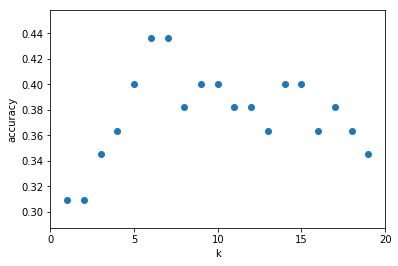

In [45]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])